# Grab Repository data      

In [1]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/releases_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [3]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")

START_DATE = None
END_DATE = None


Using INTRO_DATE from mapping file: 


# Generate Pull Request
 Metrics per Repository

## Amount of pull requests over time

In [4]:
release_result = []
add_empty = []
for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    release_file = f"{repository}/releases.csv"
    # Check if the file exists
    if not os.path.exists(release_file):
        print(f"File not found: {release_file}. Skipping repository.")
        if 'non-participants' not in release_file:
            add_empty.append(repository.split('/')[-1])
        continue
    
    try:
        release_df = pd.read_csv(release_file)

        if len(release_df) == 0:
            raise Exception
    except:
        print(f"File empty for {repository}")
        continue
    if len(release_df) > 0:
        release_df = truncate_to_same_length(release_df, INTRO_DATE, 'date', 'defined', START_DATE, END_DATE)
        release_df = aggregate_by_date(release_df, 'date', 'tag', 'count')
    else:
        add_empty.append(repository.split('/')[-1])
        print(f'Malformed release list {repository}')
    
    pre_release, post_release = split_by_date(release_df, INTRO_DATE, 'date')

    pre_release_buckets = generate_value_in_buckets(pre_release, 'date', 'count', 'sum', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'date', 'count', 'sum', BUCKET_SIZE, 'post-')
    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')['count'].to_dict())  # Use 'count' instead of 'value'
    
    release_result.append(result_row)

# Add empty repositories with NaN counts
for repo in add_empty:
    release_result.append({'repository': repo, 'count': float('nan')})

# Create the DataFrame
release_result_df = pd.DataFrame(release_result)

if len(release_result_df) == 0:
    raise ValueError("No files in any repo")

File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3/releases.csv. Skipping repository.
File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4/releases.csv. Skipping repository.
File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5/releases.csv. Skipping repository.
File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants/releases.csv. Skipping repository.


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_66857/1324198212.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)
/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_66857/1324198212.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


In [5]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(release_result_df, 'pre-', 'post-')
release_result_df = release_result_df[columns_order]

In [6]:
release_result_df.to_csv(storage_path)
release_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P9,7.0,20.0,2.0,1.0,1.0,17.0,4.0,NaN,11.0,3.0,NaN,11.0,NaN,NaN,NaN,14.0,NaN,5.0
1,P2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,2.0,4.0,NaN,1.0,4.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P1,5.0,2.0,7.0,5.0,6.0,5.0,3.0,1.0,2.0,2.0,1.0,2.0,NaN,NaN,NaN,3.0,1.0,NaN
4,5x4imrvk5b,13.0,2.0,5.0,1.0,7.0,9.0,NaN,9.0,1.0,7.0,NaN,1.0,8.0,1.0,NaN,1.0,11.0,1.0
5,P7,5.0,4.0,21.0,NaN,1.0,1.0,4.0,NaN,NaN,4.0,3.0,NaN,1.0,3.0,1.0,1.0,NaN,NaN
6,P14,11.0,22.0,2.0,1.0,14.0,9.0,4.0,7.0,NaN,2.0,NaN,NaN,11.0,14.0,5.0,10.0,NaN,NaN
7,P6,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,bznd2hh7ii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,xd8qar3azx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
release_result_df.columns

Index(['repository', 'pre-0', 'pre-1', 'pre-2', 'pre-3', 'pre-4', 'pre-5',
       'pre-6', 'pre-7', 'pre-8', 'post-0', 'post-1', 'post-2', 'post-3',
       'post-4', 'post-5', 'post-6', 'post-7', 'post-8'],
      dtype='object')

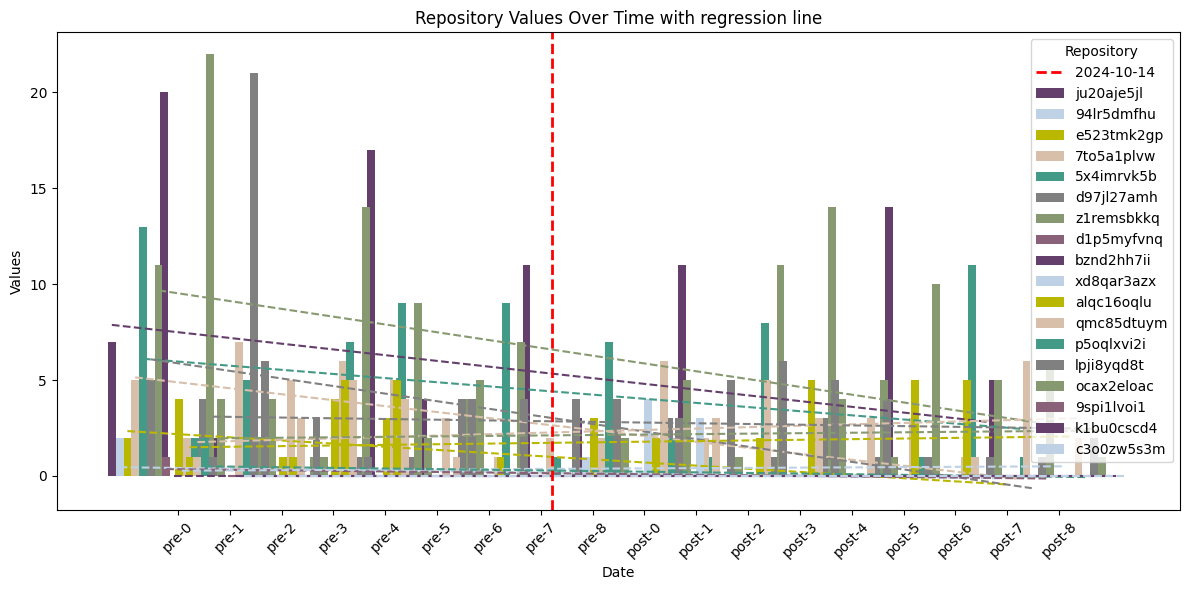

In [8]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in release_result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(release_result_df['repository']):
    # Extract data for the current repository
    values = release_result_df[release_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = release_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(release_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
# plt.yscale('log')
plt.show()

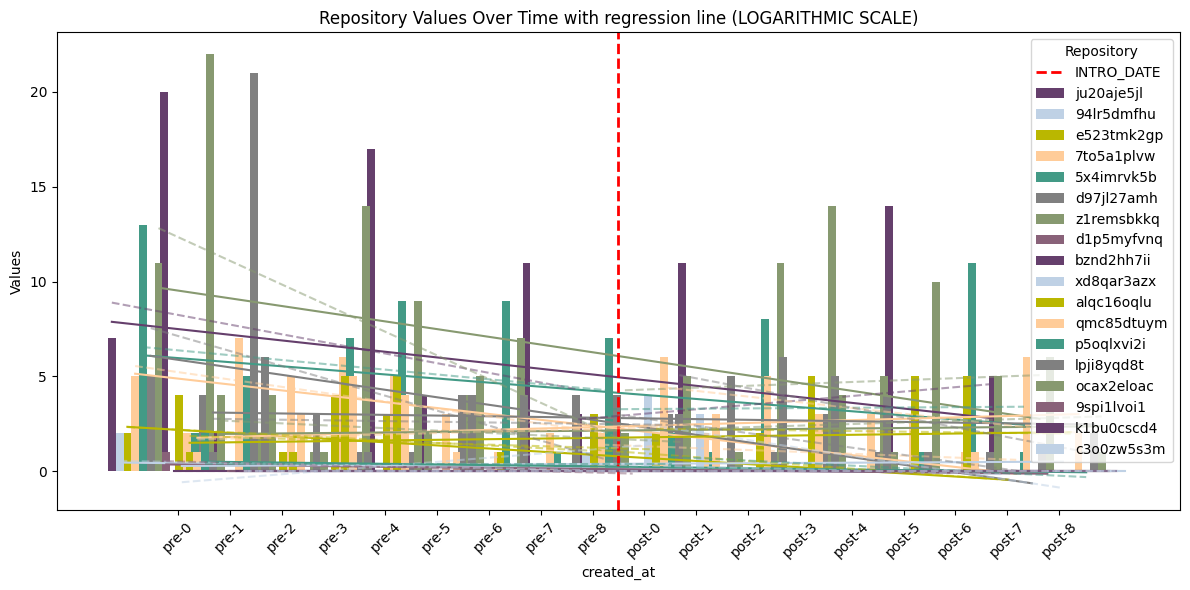

In [9]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in release_result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(release_result_df['repository']):
    # Extract data for the current repository
    values = release_result_df[release_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = release_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(release_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(release_result_df['repository']):
    values = release_result_df[release_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(release_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
# plt.yscale('log')
plt.show()

# Significancetest 

In [10]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the release_result_df
release_result_df = release_result_df.fillna(0)
print(release_result_df)
# Columns for pre and after buckets
pre_columns = [col for col in release_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in release_result_df.columns if col.startswith("post-")]

if len(pre_columns) < len(after_columns):
    release_result_df['pre-15'] = 0
    pre_columns.append('pre-15')

normality_results = check_normality_of_buckets(release_result_df, pre_columns, after_columns)


    repository  pre-0  pre-1  pre-2  pre-3  pre-4  pre-5  pre-6  pre-7  pre-8  \
0   P9    7.0   20.0    2.0    1.0    1.0   17.0    4.0    0.0   11.0   
1   P2    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2   P8    2.0    4.0    0.0    1.0    4.0    3.0    0.0    0.0    0.0   
3   P1    5.0    2.0    7.0    5.0    6.0    5.0    3.0    1.0    2.0   
4   5x4imrvk5b   13.0    2.0    5.0    1.0    7.0    9.0    0.0    9.0    1.0   
5   P7    5.0    4.0   21.0    0.0    1.0    1.0    4.0    0.0    0.0   
6   P14   11.0   22.0    2.0    1.0   14.0    9.0    4.0    7.0    0.0   
7   P6    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
8   bznd2hh7ii    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9   xd8qar3azx    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10  P4    1.0    0.0    1.0    5.0    5.0    0.0    1.0    0.0    0.0   
11  P13    1.0    0.0    3.0    5.0    4.0    1.0    0.0    0.0    0.0   
12  P12    2.0   

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, 

In [11]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, release_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)
from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(release_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P9  Cliff's Delta    -0.382716 -0.802778  0.136420
1   P2  Cliff's Delta    -0.012346 -0.333333  0.333333
2   P8  Cliff's Delta    -0.444444 -0.777778 -0.049383
3   P1  Cliff's Delta    -0.790123 -0.987654 -0.468827
4   5x4imrvk5b  Cliff's Delta    -0.296296 -0.790432  0.222222
5   P7  Cliff's Delta    -0.197531 -0.703704  0.321296
6   P14  Cliff's Delta    -0.296296 -0.765432  0.259568
7   P6  Cliff's Delta    -0.222222 -0.555556  0.000000
8   bznd2hh7ii  Cliff's Delta     0.000000  0.000000  0.000000
9   xd8qar3azx  Cliff's Delta     0.222222  0.000000  0.555556
10  P4  Cliff's Delta     0.135802 -0.370370  0.629630
11  P13  Cliff's Delta     0.456790 -0.012654  0.852160
12  P12  Cliff's Delta     0.000000 -0.333333  0.333333
13  P10  Cliff's Delta     0.148148 -0.370679  0.666667
14  P11  Cliff's Delta     0.246914 -0.296605  0.716358
15  P3  Cliff's Delta     0.000000  0.000000  0.000000
16  k1bu0cscd4  Cliff's Delt

In [12]:
merged = release_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P9,7.0,20.0,2.0,1.0,1.0,17.0,4.0,0.0,11.0,...,0.0,0.0,0.0,14.0,0.0,5.0,Cliff's Delta,-0.382716,-0.802778,0.136420
1,P2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.012346,-0.333333,0.333333
2,P8,2.0,4.0,0.0,1.0,4.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.444444,-0.777778,-0.049383
3,P1,5.0,2.0,7.0,5.0,6.0,5.0,3.0,1.0,2.0,...,0.0,0.0,0.0,3.0,1.0,0.0,Cliff's Delta,-0.790123,-0.987654,-0.468827
4,5x4imrvk5b,13.0,2.0,5.0,1.0,7.0,9.0,0.0,9.0,1.0,...,8.0,1.0,0.0,1.0,11.0,1.0,Cliff's Delta,-0.296296,-0.790432,0.222222
5,P7,5.0,4.0,21.0,0.0,1.0,1.0,4.0,0.0,0.0,...,1.0,3.0,1.0,1.0,0.0,0.0,Cliff's Delta,-0.197531,-0.703704,0.321296
6,P14,11.0,22.0,2.0,1.0,14.0,9.0,4.0,7.0,0.0,...,11.0,14.0,5.0,10.0,0.0,0.0,Cliff's Delta,-0.296296,-0.765432,0.259568
7,P6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.222222,-0.555556,0.000000
8,bznd2hh7ii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,0.000000,0.000000,0.000000
9,xd8qar3azx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,0.222222,0.000000,0.555556


# Interpretation
- 0 -> less releases after introduction
- 1, 4,5 -> more releases after introduction